In [201]:
with open('/kaggle/input/vlsp-nlp/train.en.txt', 'r', encoding='utf-8') as f:
    ens = f.read().splitlines()

with open('/kaggle/input/vlsp-nlp/train.vi.txt', 'r', encoding='utf-8') as f:
    vis = f.read().splitlines()


In [202]:
import random

for i, (en, vi) in enumerate(random.sample(list(zip(ens, vis)), 5), 1):
    print(f"Sample {i}")
    print("EN:", en)
    print("VI:", vi)
    print("-" * 40)

Sample 1
EN: Percentage of students with eyeglasses for refractive adjustment was 35.0% inwhich girls with glasses accounted for 40.9%, and boys with glasses were 28.6%. The percentage of pupils with glasses increased with age, the percentage of students with glasses at urban areas was 45.6%, which was higher than the suburbs (13.5%).
VI: Tỷ lệ học sinh mang kính điều chỉnh tật khúc xạ là 35,0% trong đó học sinh nữ (40,9%) nhiều hơn so với học sinh nam (28,6%); tỷ lệ học sinh mang kính tăng theo độ tuổi, tỷ lệ học sinh mang kính thuộc khu vực nội thành (45,6%) cao hơn so với ngoại thành (13,5%).
----------------------------------------
Sample 2
EN: Air insufflation (pneumatic otoscopy) shows poor mobility of the TM.
VI: Giảm thông khí tai giữa (ống soi tai có bơm hơi) cho thấy tính di động kém của màng nhĩ.
----------------------------------------
Sample 3
EN: These infections are more common among patients with immunocompromise due to another disorder (eg, alcohol use disorder).
VI: N

In [203]:
print(len(ens))
print(len(set(ens)))

500000
346403


In [204]:
print(len(vis))
print(len(set(vis)))

500000
345687


In [205]:
num_unique_pairs = len(set(zip(ens, vis)))
print(num_unique_pairs)

348224


# Normalize single text

In [206]:
import re

def normalize(text: str) -> str:
    text = text.strip()
    replace_map = {
        '–':'-', '—':'-', '−':'-', '﹣':'-',
        '':'≥', '':'≤',
        '∕':'/', '／':'/',
        '＝':'=',
        '＋':'+',
        '％':'%',
        '±':'±',
        '‘':"'", '’':"'",
        '“':'"', '”':'"',
    }
    for k, v in replace_map.items():
        text = text.replace(k, v)
    text = re.sub(r'\s+%', '%', text)
    text = re.sub(r'\s*/\s*', '/', text)
    text = re.sub(r'\s*-\s*', '-', text)
    for symbol in ['<', '>', '=', '±', '+', '≥', '≤']:
        text = re.sub(r'\s*{}\s*'.format(re.escape(symbol)), f' {symbol} ', text)

    def merge_numbers_only(match):
        s = match.group(0)
        return s.replace(' ', '')
    text = re.sub(r'\b\d[\d\s/.,%]*\d\b', merge_numbers_only, text)

    text = re.sub(r'([.,:?!])(?=[A-Za-zÀ-ÖØ-öø-ÿ])', r'\1 ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'(\d),\s*(\d)', r'\1,\2', text)
    text = re.sub(r'(\d)([.,])\s*(\d)', r'\1\2\3', text)
    return text

s = 'Kết quả:So sánh nhóm TAP (n+ 30) và nhóm chứng (n= 30), 1. 4/2 3 trung vị điểm VAS khi nghỉ và vận động của nhóm chứng cao hơn so với nhóm TAP.'
print(normalize(s))

Kết quả: So sánh nhóm TAP (n + 30) và nhóm chứng (n = 30), 1.4/23 trung vị điểm VAS khi nghỉ và vận động của nhóm chứng cao hơn so với nhóm TAP.


In [207]:
ens = [normalize(en) for en in ens]
vis = [normalize(vi) for vi in vis]

# Normalize pair of texts

In [208]:
def strip_special_edge(s):
    prefix = re.match(r'^[^\w\d]+', s)
    suffix = re.search(r'[^\w\d]+$', s)
    pre = prefix.group(0) if prefix else ''
    suf = suffix.group(0) if suffix else ''
    core = s[len(pre):len(s)-len(suf)] if suf else s[len(pre):]
    return pre, core, suf
    
def norm_pair(en: str, vi: str):
    bullet_pattern = r'^([a-zA-Z][\.\)])|-(?!\d)'

    en_match = re.match(bullet_pattern, en)
    vi_match = re.match(bullet_pattern, vi)
    if en_match and not vi_match:
        bullet = en_match.group(0)
        if bullet == '-':
            vi = bullet + vi.lstrip('-').lstrip()
        else:
            vi = bullet + ' ' + vi
    if vi_match and not en_match:
        bullet = vi_match.group(0)
        if bullet == '-':
            en = bullet + en.lstrip('-').lstrip()
        else:
            en = bullet + ' ' + en

    en_pre, en_core, en_suf = strip_special_edge(en)
    vi_pre, vi_core, vi_suf = strip_special_edge(vi)
    
    if en_pre != vi_pre:
        en_pre = ''
        vi_pre = ''
    
    if en_suf != vi_suf:
        en_suf = ''
        vi_suf = ''
    
    en_words = en_core.split()
    vi_words = vi_core.split()
    if en_words and en_words[0].replace('.', '').replace(',', '').isdigit():
        if vi_core.find(en_words[0]) == -1:
            en_words = en_words[1:]
    if vi_words and vi_words[0].replace('.', '').replace(',', '').isdigit():
        if en_core.find(vi_words[0]) == -1:
            vi_words = vi_words[1:]
    
    en_core = ' '.join(en_words)
    vi_core = ' '.join(vi_words)

    en = en_pre + en_core + en_suf
    vi = vi_pre + vi_core + vi_suf
    return en, vi

print(norm_pair('x) ok.', 'ok!'))
print(norm_pair('- Hello!', '- Hi!)'))
print(norm_pair('a. test', 'test'))
print(norm_pair('a) one', 'b) one'))

('x) ok', 'x) ok')
('- Hello', '- Hi')
('a. test', 'a. test')
('a) one', 'b) one')


In [209]:
ens_norm = []
vis_norm = []

for en, vi in zip(ens, vis):
    en_new, vi_new = norm_pair(en, vi)
    ens_norm.append(en_new)
    vis_norm.append(vi_new)

ens = ens_norm
vis = vis_norm

# Remove duplicate

In [210]:
def dedup_pairs(ens, vis):
    seen = set()
    new_ens, new_vis = [], []

    for en, vi in zip(ens, vis):
        pair = (en, vi)
        if pair not in seen:
            seen.add(pair)
            new_ens.append(en)
            new_vis.append(vi)

    return new_ens, new_vis
ens, vis = dedup_pairs(ens, vis)

# Remove samples that have more than 2 translation 

In [211]:
remove_ids = set()

en2vi = {}
for i in range(len(ens)):
    en = ens[i]
    if en in en2vi:
        en2vi[en].append(i)
    else:
        en2vi[en] = [i]
for en, vi_ids in en2vi.items():
    if len(vi_ids) > 1:
        remove_ids.update(vi_ids)

vi2en = {}
for i in range(len(vis)):
    vi = vis[i]
    if vi in vi2en:
        vi2en[vi].append(i)
    else:
        vi2en[vi] = [i]
for vi, en_ids in vi2en.items():
    if len(en_ids) > 1:
        remove_ids.update(en_ids)
        
len(remove_ids)

6831

In [212]:
ens = [s for i, s in enumerate(ens) if i not in remove_ids]
vis = [s for i, s in enumerate(vis) if i not in remove_ids]

# Remove sample that have only number in text

In [213]:
remove_ids = set()
for i, (en, vi) in enumerate(zip(ens, vis)):
    if not re.search(r'[A-Za-z]', en) or not re.search(r'[A-Za-z]', vi):
        remove_ids.add(i)
len(remove_ids)

29

In [214]:
ens = [s for i, s in enumerate(ens) if i not in remove_ids]
vis = [s for i, s in enumerate(vis) if i not in remove_ids]

# Remove sample that have the large diffirence length in 2 text

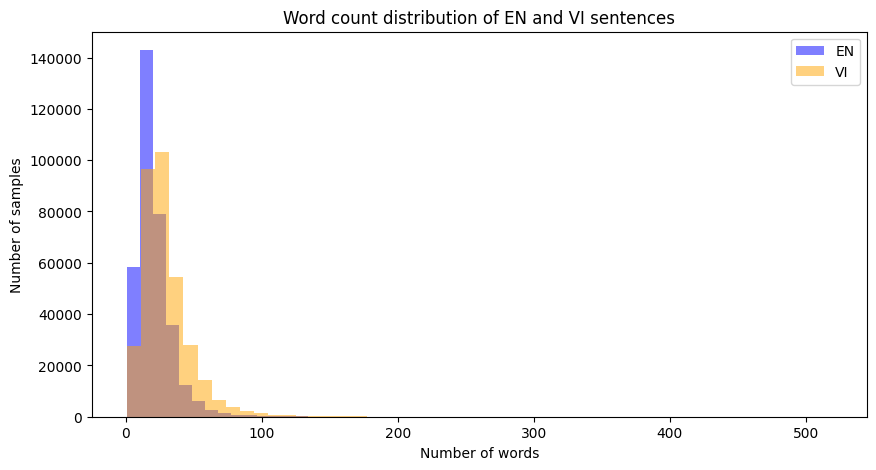

In [215]:
import matplotlib.pyplot as plt

en_lens = [len(s.strip().split()) for s in ens]
vi_lens = [len(s.strip().split()) for s in vis]

plt.figure(figsize=(10,5))
plt.hist(en_lens, bins=50, alpha=0.5, label='EN', color='blue')
plt.hist(vi_lens, bins=50, alpha=0.5, label='VI', color='orange')
plt.xlabel('Number of words')
plt.ylabel('Number of samples')
plt.title('Word count distribution of EN and VI sentences')
plt.legend()
plt.show()


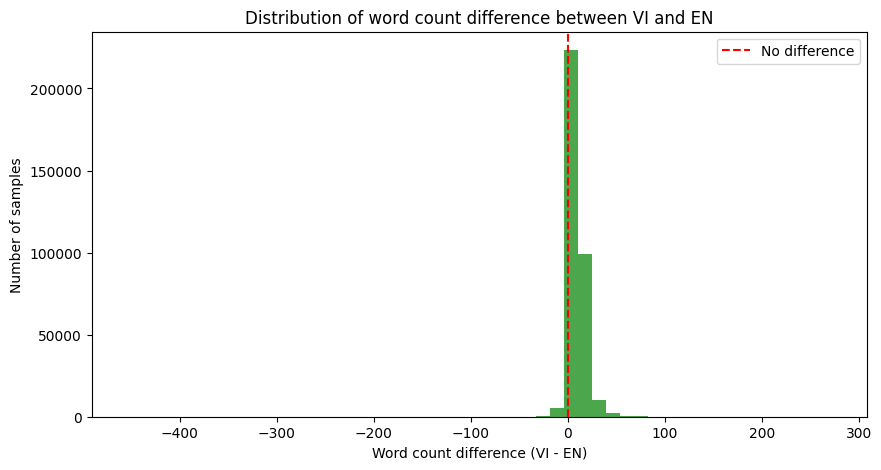

In [216]:
import matplotlib.pyplot as plt

en_lens = [len(s.strip().split()) for s in ens]
vi_lens = [len(s.strip().split()) for s in vis]

diff_lens = [vi - en for vi, en in zip(vi_lens, en_lens)]

plt.figure(figsize=(10,5))
plt.hist(diff_lens, bins=50, color='green', alpha=0.7)
plt.xlabel('Word count difference (VI - EN)')
plt.ylabel('Number of samples')
plt.title('Distribution of word count difference between VI and EN')
plt.axvline(0, color='red', linestyle='--', label='No difference')
plt.legend()
plt.show()


In [217]:
remove_ids = set()
for i, (en, vi) in enumerate(zip(ens, vis)):
    en_len = len(en.strip().split())
    vi_len = len(vi.strip().split())
    
    if en_len == 0 or vi_len == 0:
        remove_ids.add(i)
        continue
    
    if abs(vi_len - en_len) > 50:
        remove_ids.add(i)
        continue
    ratio = max(vi_len / en_len, en_len / vi_len)
    if ratio >= 3.0:
        remove_ids.add(i)

len(remove_ids)

3149

In [218]:
ens = [s for i, s in enumerate(ens) if i not in remove_ids]
vis = [s for i, s in enumerate(vis) if i not in remove_ids]

# Remove sample that the one is a part of the rest when remove space

In [219]:
remove_ids = set()
for i, (en, vi) in enumerate(zip(ens, vis)):
    if en == vi:
        continue
    en_no_space = en.replace(' ', '')
    vi_no_space = vi.replace(' ', '')
    if en_no_space in vi_no_space or vi_no_space in en_no_space:
        remove_ids.add(i)
len(remove_ids)

82

In [220]:
ens = [s for i, s in enumerate(ens) if i not in remove_ids]
vis = [s for i, s in enumerate(vis) if i not in remove_ids]

# Remove sample that lower one is a part of lower rest

In [221]:
remove_ids = set()
for i, (en, vi) in enumerate(zip(ens, vis)):
    en_lower = en.lower()
    vi_lower = vi.lower()
    if en_lower in vi_lower or vi_lower in en_lower:
        remove_ids.add(i)
len(remove_ids)

218

In [222]:
ens = [s for i, s in enumerate(ens) if i not in remove_ids]
vis = [s for i, s in enumerate(vis) if i not in remove_ids]

# Handle remove some sample that may be noise

In [223]:
for i, (en, vi) in enumerate(zip(ens, vis)):
    if en == vi:
        continue
    if len(en.split()) <= 3 or len(vi.split()) <= 3:
        print('-' * 50)
        print(i)
        print(en)
        print(vi)

--------------------------------------------------
221
Case report.
Mô tả ca bệnh.
--------------------------------------------------
1854
Adults 69.8%).
Người lớn 69,8%).
--------------------------------------------------
2304
Men was 40%.
Nam giới chiếm 40%.
--------------------------------------------------
3247
Cross-sectional, retrospective description.
Phương pháp: mô tả cắt ngang, hồi cứu.
--------------------------------------------------
3895
and Pseudomonas spp.
Và Pseudomonas spp.
--------------------------------------------------
4454
Refined with n-buthanol.
Tinh chế bằng n-buthanol.
--------------------------------------------------
4749
Sample size: 349.
Số khách thể: 349.
--------------------------------------------------
5006
Có 82,6% neutropenia.
Có 82,6% giảm bạch cầu hạt.
--------------------------------------------------
5711
Mortality is 46,7%.
Tỷ lệ tử vong là 46,7%.
--------------------------------------------------
6774
by DMSO.
bằng DMSO được tiến hành.
------

In [225]:
id_str="""
6774
9109
20363
21270
38918
55340
66375
66869
67282
69814
73816
77870
85549
91182
92791
95305
95357
95831
98855
99987
104794
108129
118069
124677
131061
131062
134440
141880
144731
146326
149586
151032
163094
169020
169841
170427
172997
176623
178611
178792
187311
208567
213528
268450
305899
306287
306776
306872
313010
313020
313023
313878
330044
"""
ids = id_str.split()
remove_ids = set()
for i in ids:
    try:
        id_int = int(i)
        remove_ids.add(i)
    except:
        continue
len(remove_ids)

53

In [226]:
ens = [s for i, s in enumerate(ens) if i not in remove_ids]
vis = [s for i, s in enumerate(vis) if i not in remove_ids]

# Save

In [227]:
print(len(ens))
print(len(vis))

337597
337597


In [228]:
with open('clean_train.en.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(ens))
with open('clean_train.vi.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(vis))